# Daten

Funktionen:
- def process_files:  zum Verarbeiten aller Files
- def test_stationarity(data, variable_name): zum Testen der Stationarität eines dataframes -> Ausgabe: Liste mit Tupeln

## Daten importieren und mergen

In [ ]:
#Daten zusammenfügen
import pandas as pd
import glob
import os
from collections import defaultdict
import pickle
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL
from scipy.stats import spearmanr
from scipy.fftpack import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hampel import hampel
import joblib



with open('test_dfs.pkl', 'rb') as f:
    test_dfs = pickle.load(f)
test_hourly = test_dfs[0]
test_daily = test_dfs[1]
test_weekly = test_dfs[2]
test_monthly = test_dfs[3]

## Daten up and downsampeln

###Allgemein
- cubic interpolation for weekly data
- median resampling for hourly data 
- cubic interpolation for monthly data 
    - divide summed value by index.days and interpolate afterwards

###Others
- fill NaN values for US LNG to Germany with 0

In [39]:
#Upsampling


#Interpolieren der Daten
for df in test_dfs: 
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True) # Setze die 'Date'-Spalte als Index
    else:
        print(f"'Date' column not found in dataframe with columns: {df.columns}")

# Resample auf tägliche Daten und Interpolation der numerischen Spalten
daily_df_from_weekly = test_weekly.resample('D').interpolate(method= 'cubic')
start_date = pd.to_datetime('2023-10-01')
if daily_df_from_weekly.index.min() > start_date:
    # Falls keine Daten ab dem 01.10.2023 vorhanden sind, reindexiere den DataFrame mit bfill
    daily_df_from_weekly = daily_df_from_weekly.reindex(pd.date_range(start=start_date, end=daily_df_from_weekly.index.max(), freq='D'))
    daily_df_from_weekly = daily_df_from_weekly.bfill()  # Backfilling der fehlenden Werte
daily_from_hourly = test_hourly.resample ('D').median()

# Resample die Daten auf täglich und führe eine Interpolation mit cubic durch
for  col in test_monthly:
    if col.startswith('A'):
        test_monthly[col] = test_monthly[col].div(test_monthly.index.days_in_month, axis=0).round(3)
        
daily_from_monthly = test_monthly.resample('D').interpolate(method='cubic')   
# Setze alle Werte bis zum Startdatum der Interpolation auf 0 im daily_from_monthly DataFrame
all_daily_dfs = [daily_df_from_weekly, daily_from_hourly, daily_from_monthly, test_daily]


#combine all daily data frames
test_final_df = pd.concat(all_daily_dfs, axis=1)
test_final_df.index = pd.to_datetime(test_final_df.index)

test_final_df = test_final_df.loc[:, ~test_final_df.columns.str.startswith('Unnamed')]
#Lag von 1 Tag einbaune, da gestrige Daten die neusten Daten sind, die vorliegen
columns_to_lag_one = [col for col in test_final_df.columns if col != 'S-Gas DA NL']

# Daten um einen Tag verschieben (Lag)
test_final_df[columns_to_lag_one] = test_final_df[columns_to_lag_one].shift(1)


# test_final_df auf drei Nachkommastellen runden
test_final_df = test_final_df.round(3)


### Up- und downgesampelte Daten plotten
Optional

In [40]:
"""# Diagramm für wöchentliche Daten
plt.figure(figsize=(15, 6))

# Plot für jede numerische Spalte in daily_df_from_weekly
for column in daily_df_from_weekly.columns:
    plt.plot(daily_df_from_weekly.index, daily_df_from_weekly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')

# Plot für jede numerische Spalte in merged_df_weekly
for column in merged_df_weekly.columns:
    plt.plot(merged_df_weekly.index, merged_df_weekly[column], label=f'Weekly Data {column}', linestyle='--', marker='o')

# Diagramm beschriften
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Weekly Data vs. Daily Interpolated Data')
plt.legend()
plt.grid(True)

    # Diagramm anzeigen
plt.show()
    # Plot für jede numerische Spalte in daily_df_from_hourly

#Diagramm für stündliche Daten
plt.figure(figsize=(15, 6))
for column in daily_from_hourly.columns:
    plt.plot(daily_from_hourly.index, daily_from_hourly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')
# Plot für jede numerische Spalte in merged_df_hourly
for column in merged_df_hourly.columns:
    plt.plot(merged_df_hourly.index, merged_df_hourly[column], label=f'Hourly Data {column}', linestyle='--', marker='o')

# Legende, Achsentitel und Anzeige des Plots
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.title("Vergleich: Daily Interpolated vs. Hourly Data")
plt.legend()
plt.grid(True)
plt.show()"""

"""#alle monatlichen in getrennten plots plotten
num_columns = len(daily_from_monthly.columns)  # Anzahl der Spalten
fig, axes = plt.subplots(num_columns, 1, figsize=(15, 6 * num_columns))

# Wenn es nur eine Spalte gibt, sorgt dieser Code dafür, dass axes eine einzelne Achse ist
if num_columns == 1:
    axes = [axes]

# Gehe jede Spalte durch und erstelle ein Diagramm
for i, column in enumerate(daily_from_monthly.columns):
    # Daily Interpolated plot
    axes[i].plot(daily_from_monthly.index, daily_from_monthly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')

    # Monthly Data plot
    axes[i].plot(merged_df_monthly.index, merged_df_monthly[column], label=f'Monthly Data {column}', linestyle='--', marker='o')

    # Achsenbeschriftungen und Titel
    axes[i].set_xlabel("Datum")
    axes[i].set_ylabel("Wert")
    axes[i].set_title(f"Vergleich: Daily Interpolated vs. Monthly Data ({column})")
    axes[i].legend()
    axes[i].grid(True)

# Layout anpassen, um Überschneidungen zu vermeiden
plt.tight_layout()
plt.show()"""



'#alle monatlichen in getrennten plots plotten\nnum_columns = len(daily_from_monthly.columns)  # Anzahl der Spalten\nfig, axes = plt.subplots(num_columns, 1, figsize=(15, 6 * num_columns))\n\n# Wenn es nur eine Spalte gibt, sorgt dieser Code dafür, dass axes eine einzelne Achse ist\nif num_columns == 1:\n    axes = [axes]\n\n# Gehe jede Spalte durch und erstelle ein Diagramm\nfor i, column in enumerate(daily_from_monthly.columns):\n    # Daily Interpolated plot\n    axes[i].plot(daily_from_monthly.index, daily_from_monthly[column], label=f\'Daily Interpolated {column}\', linestyle=\'-\', marker=\'\')\n\n    # Monthly Data plot\n    axes[i].plot(merged_df_monthly.index, merged_df_monthly[column], label=f\'Monthly Data {column}\', linestyle=\'--\', marker=\'o\')\n\n    # Achsenbeschriftungen und Titel\n    axes[i].set_xlabel("Datum")\n    axes[i].set_ylabel("Wert")\n    axes[i].set_title(f"Vergleich: Daily Interpolated vs. Monthly Data ({column})")\n    axes[i].legend()\n    axes[i].grid

## 1. Data Preprocessing

### 1.1 Data Anomalies - Outliers and Missing values

#### Outliers
- drop all weekend data
- convert UnPlanned Unavailability into binary format
- check whether data frame only hold numerical values
- drop all columns that do not differ from others besides unit
- insert new columns with sum of US export terminals

In [41]:
# Tage extrahieren
test_final_df['Day'] = test_final_df.index.weekday+1

test_final_df = test_final_df[~test_final_df['Day'].isin([6,7])]
test_final_df = test_final_df.drop(columns=['Day'])


test_final_df['A- UnPlanned Unavailability Norway'] = (test_final_df['A- UnPlanned Unavailability Norway'] == 'Unplanned').astype(int)

#Check whether the data frame only hold numerical values
for column in test_final_df:
    if test_final_df[column].dtype == 'object':
        print(test_final_df[column].name)
        
## First Feature Selection
test_final_df =test_final_df.drop(columns=['A-Annual Consumption (TWh)', 'A- Gas stprage Technical Capacity (TWh)', 'A-Injection capacity (GWh/d)','N-Withdrawal capacity (GWh/d)','A-LNG Inventory (10³ ? LNG)', 'A-Technical Capacity / DTMI (10³ ? LNG)']) 

# Neue Spalte zu Exportterminals LNG in USA hinzufügen
lng_columns = [col for col in test_final_df.columns if col.startswith('A-LNG US')]
test_final_df['A-US LNG Exportterminals'] = test_final_df[lng_columns].sum(axis=1).round(3)

# Lösche die ursprünglichen 'A-LNG US'-Spalten
test_final_df.drop(columns=lng_columns, inplace=True)

#### Handle missing values 
- delete all coumns with missing values > 40%
- interpolate single misisng values linear
- unify units 

### Selected features

In [43]:
#### 1. Feature Selection 
columns_to_drop = ['A-LNG Inventory (~GWh)', 'A-Send-Out (GWh/d)','A-US LNG to Germany','A- UnPlanned Unavailability Norway',
'N&P-Geschaeftslage (Deutschland)',
    'N&P-Geschaeftserwartungen (Deutschland)',
    'N&P-Geschaeftsklima (verarbeitendes Gewerbe)',
    'N&P-Geschaeftslage (verarbeitendes Gewerbe)',
    'N&P-Geschaeftserwartungen (verarbeitendes Gewerbe)',
    'P-Germany_News_Index',
    'A-Gas in storage (TWh)',
    'A-gas storage Trend (%)',
    'A-Stock/Cons (%)',
    'A-Gas Injection (GWh/d)',
    'N- Gas Withdrawal (GWh/d)',
    'A-Norway Exit Nomination',
    'A-Technical Capacity / DTMI (~GWh)',
    'A-Send-out capacity (GWh/d)',
    'K-Sunshine in s',
    'P-EXY (BidNet)',
    'S-Gas DA UK',
    'S-Gas DA FR',
    'S-Gas DA AU',
    'S-Gas DA IT',
    'S-Coal Channel (Max)',
    'S-Coal Channel (Min)',
    'S-Coal Switching Price Average',
    'A-US LNG Exportterminals',
    'A-Flow Norway to Continent (excl UK)',
    'A-Flow Norway to UK',
    'A-Flow Russian Three Main Lines',
    'A-Flow Russia to Bulgaria (TurkStream 2)',
    'A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)',
    'A-Flow Russia to Hungary (Net VIP Bereg)',
    'A-Flow North African Piped',
    'A-Flow UK LNG Sendout',
    'A-Flow Continental LNG Sendout', #wird irgendwie nicht gedropped??
    'A-Flow Azerbaijan via TAP to Italy'
]
selected_features_cross =['S-Coal Price (close)', 'A-Flow North African Piped', 'A-Flow UK LNG Sendout', 'A-Flow Azerbaijan via TAP to Italy', 'N&P-Geschaeftsklima (Deutschland)', 'N&P-Geschaeftserwartungen (Deutschland)', 'N&P-Geschaeftsklima (verarbeitendes Gewerbe)', 'N&P-Geschaeftslage (verarbeitendes Gewerbe)', 'N&P-Geschaeftserwartungen (verarbeitendes Gewerbe)', 'A-gas storage Trend (%)', 'A-LNG Inventory (~GWh)', 'A-Technical Capacity / DTMI (~GWh)', 'A-Send-out capacity (GWh/d)', 'K-Temperatur 2m', 'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA UK', 'S-Gas DA FR', 'S-Gas DA D', 'S-Gas DA AU', 'S-Gas DA IT', 'S-Coal Channel (Max)', 'S-Coal Channel (Min)', 'S-Coal Switching Price Average', 'S-CO2 Price']
selected_features_granger = ['S-Coal Price (close)', 'S-Power price', 'A-Flow Norway to UK', 'A-Flow Russia to Bulgaria (TurkStream 2)', 'A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)', 'A-Flow UK LNG Sendout', 'A-Flow Continental LNG Sendout ', 'A-Flow Azerbaijan via TAP to Italy', 'A-US LNG to Germany', 'A-Importiertes Erdgas Deutschland', 'N&P-Geschaeftsklima (Deutschland)', 'N&P-Geschaeftslage (Deutschland)', 'N&P-Geschaeftserwartungen (Deutschland)', 'N&P-Geschaeftsklima (verarbeitendes Gewerbe)', 'N&P-Geschaeftslage (verarbeitendes Gewerbe)', 'P-European_News_Index', 'P-Germany_News_Index', 'P-GPR', 'A-Gas in storage (TWh)', 'A-Gas storage Full (%)', 'A-gas storage Trend (%)', 'A-Stock/Cons (%)', 'A-Gas Injection (GWh/d)', 'A-LNG Inventory (~GWh)', 'A-Technical Capacity / DTMI (~GWh)', 'K-Temperatur 2m', 'K-Sunshine in s', 'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA UK', 'S-Gas DA D', 'S-Gas DA AU', 'S-Gas DA IT', 'S-Coal Channel (Max)', 'S-Coal Channel (Min)', 'S-Coal Switching Price Average', 'S-CO2 Price', 'A-US LNG Exportterminals']
selected_features_corr = ['A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)', 'N&P-Geschaeftserwartungen (Deutschland)', 'N&P-Geschaeftslage (verarbeitendes Gewerbe)', 'N&P-Geschaeftserwartungen (verarbeitendes Gewerbe)', 'A-Gas storage Full (%)', 'A-Stock/Cons (%)', 'N- Gas Withdrawal (GWh/d)', 'A-Technical Capacity / DTMI (~GWh)', 'A-Send-Out (GWh/d)', 'A-Send-out capacity (GWh/d)', 'N-Demand LDZ', 'S-Gas DA AU', 'S-Gas DA IT', 'S-Coal Channel (Max)', 'S-Coal Channel (Min)', 'S-Coal Switching Price Average']
selected_features_cross= ['S-Coal Price (close)', 'S-Power price', 'P-European_News_Index', 'P-EXY Average ', 'S-Gas DA D']
# Spalten entfernen
test_final_df = test_final_df.drop(columns=columns_to_drop, errors='ignore')

#test_final_df = test_final_df[selected_features_cross]
#test_final_df = test_final_df[selected_features_granger]
#test_final_df = test_final_df.drop(columns = selected_features_corr, errors = 'ignore')

            S-Gas DA NL
2023-10-02        32.70
2023-10-03        30.85
2023-10-04        32.55
2023-10-05        28.45
2023-10-06        33.55


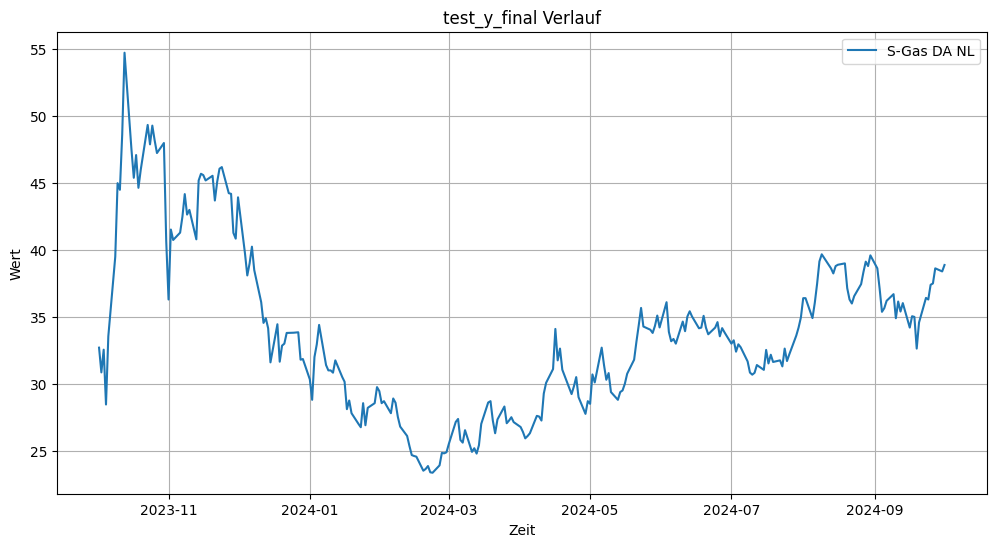

In [44]:
print (test_y_final.head())
plt.figure(figsize=(12, 6))
plt.plot(test_y_final, label=test_y_final.columns[0])  # Falls nur 1 Spalte
plt.title('test_y_final Verlauf')
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.legend()
plt.grid(True)
plt.show()

### 1.2 Log Transformation und Stationarity Test (nur für Testzwecke)

#### Differenzierung
- wahrscheinlcih mehr als 1 nötig 

In [ ]:
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']

def apply_diff_order(df, diff_order_df):
    # Kopie des DataFrames erstellen, um Originaldaten zu erhalten
    df_diffed = df.copy()
    
    # Iteriere über jede Zeile im diff_order_df
    for _, row in diff_order_df.iterrows():
        col_name = row['Column']  # Spaltenname
        diff_order = row['Diff Order']  # Differenzierungsordnung
        
        # Überprüfen, ob die Spalte im DataFrame existiert
        if col_name in df.columns:
            series = df_diffed[col_name]
            
            # Differenzierung für die angegebene Anzahl an Differenzierungsordnungen anwenden
            for _ in range(diff_order):
                series = series.diff()  # diff anwenden
            df_diffed[col_name] = series
            df_diffed[col_name] = df_diffed[col_name].bfill()
        else:
            print(f"Spalte '{col_name}' nicht im DataFrame gefunden!")

    return df_diffed

test_final_df_diff = apply_diff_order(test_final_df, train_diff_order)
#test_y_final_diff = apply_diff_order(test_y_final, train_y_diff_order)

## Feature Engineering

### Feature Extraction

#### Seasonality testing 

In [48]:
#Saisonalität
list_yearly_seasonality = [col for col in ['S-Coal Price (close)', 'A-Importiertes Erdgas Deutschland', 'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR', 'A-Gas storage Full (%)', 'K-Temperatur 2m', 'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA D', 'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Power price'] if col in test_final_df.columns]
list_monthly_seasonality = [col for col in ['N-Demand non-LDZ', 'N-Demand LDZ'] if col in test_final_df.columns]
list_weekly_seasonality = [col for col in ['S-Power price'] if col in test_final_df.columns]
"""
#ACF 
for spalte in list_seasonality:
    plt.figure(figsize=(12, 6))
    plot_acf(test_final_df[spalte], lags=400, ax=plt.gca())  # lags anpassen
    plt.title(f'ACF - {spalte}')
    plt.xlabel('Lag')
    plt.ylabel('Autokorrelation')
    plt.show()

#STL aller Inputs
final_df_from_062023 = test_final_df.loc['2023-05-01':]
for column in final_df_from_062023.columns:
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))  # Erstellt ein 4x1-Raster für die Plots

    # ACF-Plot
    plot_acf(final_df_from_062023[column], lags=380, ax=axes[0])
    axes[0].set_title(f'Autokorrelation - {column}')

    # STL-Dekomposition
    try:
        stl = STL(final_df_from_062023[column], period=170)
        res = stl.fit()
        res.observed.plot(ax=axes[1])
        axes[1].set_title(f'Original - {column}')
        res.trend.plot(ax=axes[2])
        axes[2].set_title(f'Trend - {column}')
        res.seasonal.plot(ax=axes[3])
        axes[3].set_title(f'Saisonalität - {column}')
        res.resid.plot(ax=axes[4])
        axes[4].set_title(f'Residuen - {column}')

    except Exception as e:
        print(f"STL-Dekomposition für {column} fehlgeschlagen: {e}")

    plt.tight_layout()  # Sorgt für eine bessere Anordnung der Plots
    plt.show() # Zeigt alle Plots in einem Bild an"""
#ACF für alle Input Variablen
"""final_df_march_2022 = test_final_df.loc['2022-03-01':]
variables = test_final_df.columns
num_vars = len(variables)

cols = 3
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))

if num_vars == 1:
    axes = [axes]

for i, var in enumerate(variables):
    ax = axes[i // cols, i % cols]
    plot_acf(final_df_march_2022[var].dropna(), ax=ax, lags=600)
    ax.set_title(f"ACF für {var}")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()"""


#Jede Spalte im DataFrame plotten
"""def plot_all_columns(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))  # Erstellt eine neue Figur für jede Spalte
        plt.plot(df[column])
        plt.title(f"Plot für {column}")
        plt.xlabel("Index")
        plt.ylabel("Wert")
        plt.show()
plot_all_columns(test_final_df)"""

# Plot y_final
"""y_final_2023 = y_final.loc['2023-01-01':]

y_final_2023.plot(figsize=(12, 6))
plt.title('Plot von y_final')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.grid(True)
plt.show()"""



"y_final_2023 = y_final.loc['2023-01-01':]\n\ny_final_2023.plot(figsize=(12, 6))\nplt.title('Plot von y_final')\nplt.xlabel('Datum')\nplt.ylabel('Wert')\nplt.grid(True)\nplt.show()"

#### Lag features oder (rolling) window
Beeded to convert time-series into Machine Learning problem
- test with ACF and PACF to determine the number of legs 
- might be useful to determine lags first and differentiate afterwards since teh models do not need stationarity

In [ ]:
#für Testzwecke mit kleinerem Datensatz
short_test_df = test_final_df
with open('short_test_df.pkl', 'wb') as f:
    pickle.dump(short_test_df, f)

#### Cyclic Features


In [ ]:



# ---- 1. Konfiguration ----

# Manuell definierte saisonale Features
features_seasonality = [
    'K-Wind speed', 'N-Demand', 'N&P-Geschaeftsklima', 'S-Power price'
]

# Gruppenzuweisung nach Präfix
group_map = {
    "S-": "price",
    "K-": "climate",
    "A-": "storage",
    "N-": "demand",
    "P-": "policy",
    "N&P": "policy"  # Spezialfall für zusammengesetzte Bezeichner
}

# Erweiterte saisonale Lags (falls noch nicht vorhanden)
list_yearly_seasonality = [
    col for col in [
        'S-Coal Price (close)', 'A-Importiertes Erdgas Deutschland',
        'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR',
        'A-Gas storage Full (%)', 'K-Temperatur 2m',
        'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA D',
        'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Power price'
    ] if col in test_final_df.columns
]

list_monthly_seasonality = [
    col for col in ['N-Demand non-LDZ', 'N-Demand LDZ'] if col in test_final_df.columns
]

list_weekly_seasonality = [
    col for col in ['S-Gas DA D', 'S-Power price'] if col in test_final_df.columns
]

# ---- 2. Gruppierung der Spalten nach Präfix ----
grouped_features = defaultdict(list)

for col in test_final_df.columns:
    assigned = False
    for prefix, group in group_map.items():
        if col.startswith(prefix):
            grouped_features[group].append(col)
            assigned = True
            break
    if not assigned:
        grouped_features["other"].append(col)

# ---- 3. Feature-Ableitung nach Gruppenzugehörigkeit ----
all_features = []

for group, var_list in grouped_features.items():
    for col in var_list:
        base = test_final_df[col]
        out = pd.DataFrame(index=test_final_df.index)

        # Alle kriegen lag1
        out[f"{col}_lag1"] = base.shift(1)

        # Saisonale Lags, wenn zutreffend
  

        if group == "price":
            out[f"{col}_lag7"] = base.shift(7)
            out[f"{col}_rollmean_3"] = base.rolling(3, min_periods=1).mean()
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollstd_3"] = base.rolling(3, min_periods=1).std()
            out[f"{col}_rollmax_7"] = base.rolling(7, min_periods=1).max()

        elif group == "climate":
            out[f"{col}_lag7"] = base.shift(7)
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()
            out[f"{col}_rollstd_7"] = base.rolling(7, min_periods=1).std()
            out[f"{col}_rollmin_7"] = base.rolling(7, min_periods=1).min()
            out[f"{col}_rollmax_7"] = base.rolling(7, min_periods=1).max()

        elif group == "demand":
            out[f"{col}_lag7"] = base.shift(7)
          #  out[f"{col}_lag365"] = base.shift(365)
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()
            out[f"{col}_rollstd_30"] = base.rolling(30, min_periods=1).std()

        elif group == "storage":
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollmin_7"] = base.rolling(7, min_periods=1).min()

        elif group == "policy":
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()

        all_features.append(out)

# ---- 4. DataFrame zusammenführen ----
features_df = pd.concat(all_features, axis=1)
test_final_df = pd.concat([test_final_df, features_df], axis=1)

# ---- 5. Zusätzliche saisonale Lags, falls noch nicht vorhanden ----

for col in list_monthly_seasonality:
    lag_col = f"{col}_lag30"
    if lag_col not in test_final_df.columns:
        test_final_df[lag_col] = test_final_df[col].shift(30)

for col in list_weekly_seasonality:
    lag_col = f"{col}_lag7"
    if lag_col not in test_final_df.columns:
        test_final_df[lag_col] = test_final_df[col].shift(7)

# ---- 6. NaN-Behandlung & Finalisierung ----
test_final_df = test_final_df.interpolate().bfill().ffill().astype('float32')

In [53]:
"""# Beispielhafte Interaktionskonstruktionen:
test_final_df["Gas_Dx_LDZmean30"] = (
    test_final_df["S-Gas DA D"] * test_final_df["N-Demand LDZ_rollmean_30"]
)

test_final_df["GasLag1_x_Wind7"] = (
    test_final_df["S-Gas DA D_lag1"] * test_final_df["K-Wind speed_rollmean_7"]
)

test_final_df["CoalStd_x_TempMin"] = (
    test_final_df["S-Coal Price (close)_rollstd_3"] * test_final_df["K-Wind speed_rollmin_7"]
)

test_final_df["NonLDZ_vs_LDZ"] = (
    test_final_df["N-Demand non-LDZ_lag30"] / test_final_df["N-Demand LDZ_rollmean_30"]
)

test_final_df["News30_x_Gas"] = (
    test_final_df["P-European_News_Index_rollmean_30"] * test_final_df["S-Gas DA D"]
)

test_final_df["Gas_diff_lag1"] = (
    test_final_df["S-Gas DA D"] - test_final_df["S-Gas DA D_lag1"]
)

test_final_df["LDZ_std_ratio"] = (
    test_final_df["N-Demand LDZ_rollstd_30"] / test_final_df["N-Demand LDZ_rollmean_30"]
)
"""


'# Beispielhafte Interaktionskonstruktionen:\ntest_final_df["Gas_Dx_LDZmean30"] = (\n    test_final_df["S-Gas DA D"] * test_final_df["N-Demand LDZ_rollmean_30"]\n)\n\ntest_final_df["GasLag1_x_Wind7"] = (\n    test_final_df["S-Gas DA D_lag1"] * test_final_df["K-Wind speed_rollmean_7"]\n)\n\ntest_final_df["CoalStd_x_TempMin"] = (\n    test_final_df["S-Coal Price (close)_rollstd_3"] * test_final_df["K-Wind speed_rollmin_7"]\n)\n\ntest_final_df["NonLDZ_vs_LDZ"] = (\n    test_final_df["N-Demand non-LDZ_lag30"] / test_final_df["N-Demand LDZ_rollmean_30"]\n)\n\ntest_final_df["News30_x_Gas"] = (\n    test_final_df["P-European_News_Index_rollmean_30"] * test_final_df["S-Gas DA D"]\n)\n\ntest_final_df["Gas_diff_lag1"] = (\n    test_final_df["S-Gas DA D"] - test_final_df["S-Gas DA D_lag1"]\n)\n\ntest_final_df["LDZ_std_ratio"] = (\n    test_final_df["N-Demand LDZ_rollstd_30"] / test_final_df["N-Demand LDZ_rollmean_30"]\n)\n'

#### Scaling

In [55]:

min_max_scaler = joblib.load('min_max_scaler.pkl')

# 2. Auswahl der numerischen Spalten (alle außer der 'Date' Spalte)
numerical_columns = test_final_df.select_dtypes(include=['float32']).columns
print(numerical_columns)
scaled_test_data = min_max_scaler.transform(test_final_df[numerical_columns])

scaled_test_final_df = pd.DataFrame(scaled_test_data, columns=numerical_columns, index=test_final_df.index)

#print(scaled_test_final_df)

y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

# 2. Auswahl der numerischen Spalten (alle außer der 'Date' Spalte)
test_y_dinal_df = test_y_final.astype('float32')
numerical_columns = test_y_final.select_dtypes(include=['float64','int32']).columns
print(numerical_columns)
scaled_test_y_data = y_min_max_scaler.transform(test_y_final[numerical_columns])

scaled_test_y_final_df = pd.DataFrame(scaled_test_y_data, columns=numerical_columns, index=test_y_final.index)

print(scaled_test_y_final_df)
unscaled_test_final_df = test_final_df.copy()
unscaled_test_y_final = test_y_final.copy()
test_final_df = scaled_test_final_df
test_y_final = scaled_test_y_final_df

Index(['S-Coal Price (close)', 'K-Wind speed', 'S-Power price',
       'A-Flow Continental LNG Sendout ', 'A-Importiertes Erdgas Deutschland',
       'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR',
       'A-Gas storage Full (%)', 'K-Temperatur 2m', 'N-Demand non-LDZ',
       'N-Demand LDZ', 'P-Schluss DXY ', 'P-EXY Average ', 'S-Gas DA D',
       'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Coal Price (close)_lag1',
       'S-Coal Price (close)_lag7', 'S-Coal Price (close)_rollmean_3',
       'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3',
       'S-Coal Price (close)_rollmax_7', 'S-Power price_lag1',
       'S-Power price_lag7', 'S-Power price_rollmean_3',
       'S-Power price_rollmean_7', 'S-Power price_rollstd_3',
       'S-Power price_rollmax_7', 'S-Gas DA D_lag1', 'S-Gas DA D_lag7',
       'S-Gas DA D_rollmean_3', 'S-Gas DA D_rollmean_7',
       'S-Gas DA D_rollstd_3', 'S-Gas DA D_rollmax_7',
       'S-Oil Spot Price (Brent)_lag1', 'S

#### Encoding und Dummies

In [56]:
# Add cyclic dummies

test_final_df['Month'] = test_final_df.index.month_name()
test_final_df['Season'] = test_final_df['Month'].apply(lambda m: 'Summer' if m in ['May', 'June', 'July', 'August', 'Septembre'] else 'Winter')
# One-Hot-Encoding für Saison und Monat, benannt als Saison_Sommer, Saison_Winter und Monat_1 bis Monat_12
test_final_df = pd.get_dummies(test_final_df, columns=['Season'], drop_first=False, dtype= int)
test_final_df = test_final_df.drop(columns=['Month'], axis=1)

In [57]:
test_df = test_final_df
test_df = test_df.bfill()
test_y_df = test_y_final
with open('test_df.pkl', 'wb') as f:
    pickle.dump(test_df, f)
with open('test_y_df.pkl', 'wb') as f:
    pickle.dump(test_y_df, f)

In [58]:

unscaled_test_final_df['Month'] = unscaled_test_final_df.index.month_name()
unscaled_test_final_df['Season'] = unscaled_test_final_df['Month'].apply(lambda m: 'Summer' if m in ['May', 'June', 'July', 'August', 'Septembre'] else 'Winter')
# One-Hot-Encoding für Saison und Monat, benannt als Saison_Sommer, Saison_Winter und Monat_1 bis Monat_12
unscaled_test_final_df = pd.get_dummies(unscaled_test_final_df, columns=['Season'], drop_first=False, dtype= int)
unscaled_test_final_df = unscaled_test_final_df.drop(columns=['Month'], axis=1)

In [59]:

unscaled_test_final_df = unscaled_test_final_df.bfill()
with open('unscaled_test_final_df.pkl', 'wb') as f:
    pickle.dump(unscaled_test_final_df, f)
with open('unscaled_test_y.pkl', 'wb') as f:
    pickle.dump(unscaled_test_y_final, f)

In [60]:
print (test_y_df)

            S-Gas DA NL
2023-10-02     0.029276
2023-10-03     0.022604
2023-10-04     0.028735
2023-10-05     0.013947
2023-10-06     0.032342
...                 ...
2024-09-25     0.046228
2024-09-26     0.046589
2024-09-27     0.050664
2024-09-30     0.049835
2024-10-01     0.051566

[262 rows x 1 columns]
